In [72]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
print('loading data...')
with open('data/mnist.pkl', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print('done')

loading data...
done


In [74]:
# Unpack sets
train_x, train_y = train_set
test_x, test_y = test_set

# Convert to DataFrames
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y, columns=['label'])
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y, columns=['label'])

In [75]:
from sklearn.decomposition import PCA

PCA_model = PCA(n_components=2).fit(train_x)
PCA_train_x = PCA_model.transform(train_x)
PCA_test_x = PCA_model.transform(test_x)

print("PCA_train_x:", PCA_train_x.shape)
print("PCA_test_x :", PCA_test_x.shape)

PCA_train_x: (50000, 2)
PCA_test_x : (10000, 2)


Text(0, 0.5, 'Principal Component 2')

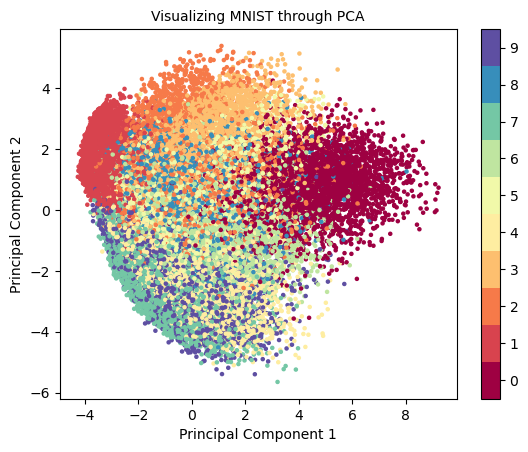

In [76]:
# Plot the PCA result
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], s=5, c=train_y['label'], cmap='Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through PCA', fontsize=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [77]:
sub_PCA_train_x = PCA_train_x[:1000, :]
sub_train_y = train_y[:1000]
print('sub_PCA_train_x.shape: ', sub_PCA_train_x.shape)

sub_PCA_train_x.shape:  (1000, 2)


In [78]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

li = 'average'
n_c = 10

hier = AgglomerativeClustering(n_clusters=n_c, metric='euclidean', linkage=li)
pred_y = hier.fit_predict(sub_PCA_train_x)

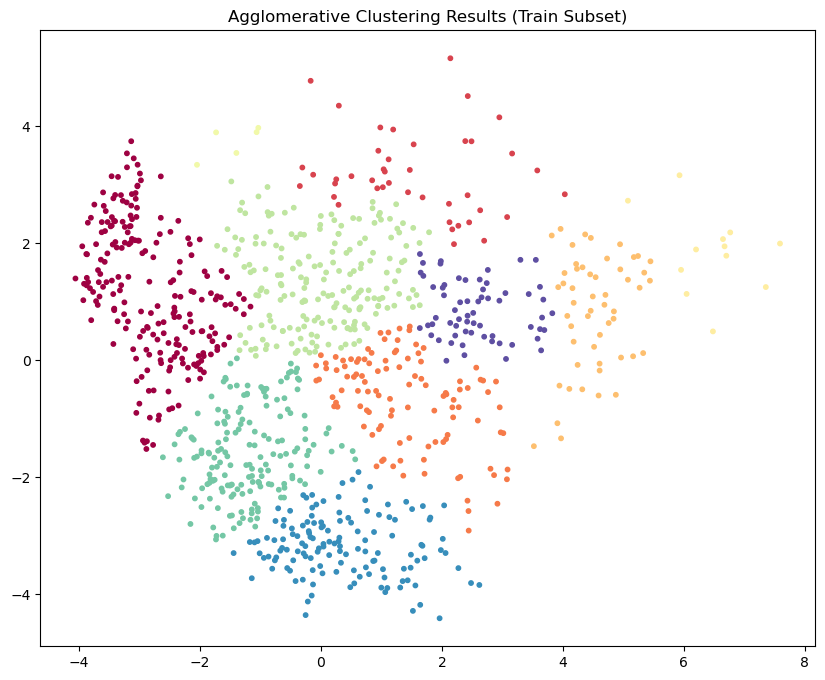

In [79]:
plt.figure(figsize=(10, 8))
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], c=pred_y, cmap='Spectral', s=10)
plt.title('Agglomerative Clustering Results (Train Subset)')
plt.show()

In [80]:
sub_PCA_train_x = PCA_train_x[:1000, :]
sub_train_y = train_y[:1000]
print('sub_PCA_train_x.shape: ', sub_PCA_train_x.shape)

sub_PCA_train_x.shape:  (1000, 2)


In [81]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

li = 'average'
n_c = 10

hier = AgglomerativeClustering(n_clusters=n_c, metric='euclidean', linkage=li)
pred_y = hier.fit_predict(sub_PCA_train_x)

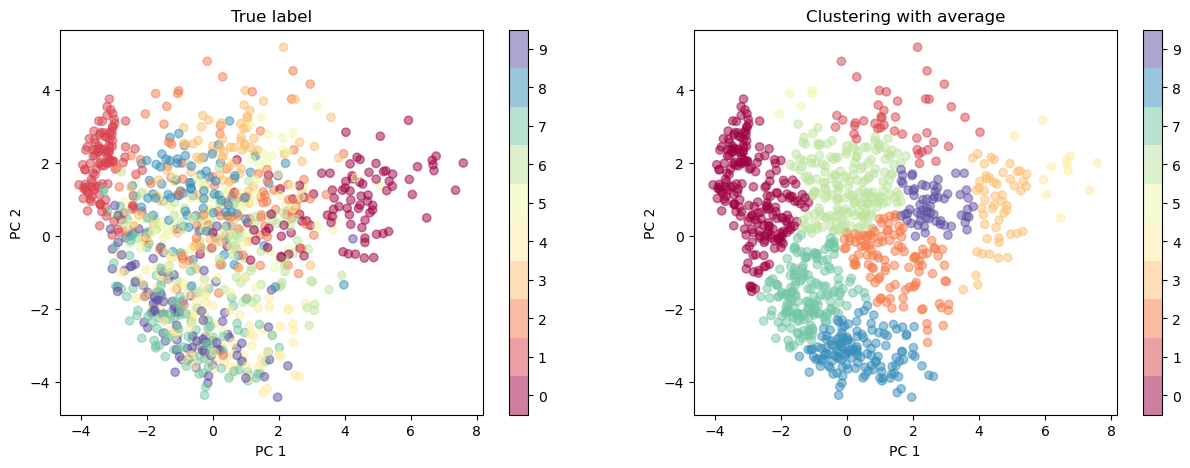

In [82]:
## Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1],
            c=sub_train_y['label'], cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("True label")
plt.xlabel('PC 1'); plt.ylabel('PC 2')

plt.subplot(1, 2, 2)
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1],
            c=pred_y, cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(n_c+1)-0.5).set_ticks(np.arange(n_c))
plt.title("Clustering with " + li)
plt.xlabel('PC 1'); plt.ylabel('PC 2')

plt.show()

### How well do the clusters match the ground truth digit labels?
잘 일치하지 않는 것 처럼 보인다. 다만 숫자 1, 0의 경우 실제 라벨에서도 따로 구별돼있는 모습을 보여서 구별을 어느정도 해내는 것 같다.<br>
다른 숫자들은 너무 섞여있어서 클러스터링이 쉽지않아 보인다.

In [83]:
sub_PCA_test_x = PCA_test_x[:100, :]
sub_test_y = test_y[:100]

pred_test_y = hier.fit_predict(sub_PCA_test_x)

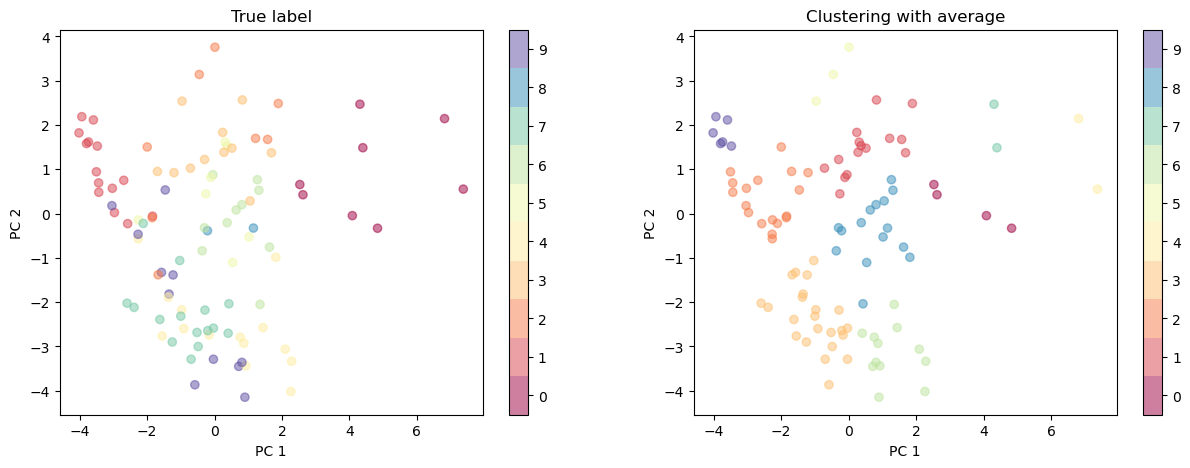

In [84]:
## Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(sub_PCA_test_x[:, 0], sub_PCA_test_x[:, 1],
            c=sub_test_y['label'], cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("True label")
plt.xlabel('PC 1'); plt.ylabel('PC 2')

plt.subplot(1, 2, 2)
plt.scatter(sub_PCA_test_x[:, 0], sub_PCA_test_x[:, 1],
            c=pred_test_y, cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(n_c+1)-0.5).set_ticks(np.arange(n_c))
plt.title("Clustering with " + li)
plt.xlabel('PC 1'); plt.ylabel('PC 2')

plt.show()

### Which clusters capture digits well? 
6, 9, 0 클러스터가 그래도 절반 정도 일치하는 것 같아 보인다.
### Where confusion arises visually?
PC1의 -2~2 사이의 범위가 시각적 혼란이 발생한다.

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linear_sum_assignment

def compute_cluster_accuracy(y_true, y_pred, n_clusters):
    # (1) Compute confusion matrix (rows = true labels, columns = cluster IDs)
    conf_mat = confusion_matrix(y_true, y_pred, labels=np.arange(n_clusters))
    
    # (2) Find optimal mapping using Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    mapping = dict(zip(col_ind, row_ind))  # cluster -> digit
    
    # (3) Relabel predicted clusters
    mapped_preds = np.array([mapping[cluster] for cluster in y_pred])
    
    # (4) Compute accuracy and remapped confusion matrix
    acc = accuracy_score(y_true, mapped_preds)
    mapped_conf_mat = confusion_matrix(y_true, mapped_preds)
    
    return acc, mapped_conf_mat, mapped_preds

In [86]:
# Train set evaluation
train_acc, train_conf, train_mapped = compute_cluster_accuracy(
    sub_train_y['label'], pred_y, n_clusters=n_c)

# Test set evaluation
test_acc, test_conf, test_mapped = compute_cluster_accuracy(
    sub_test_y['label'], pred_test_y, n_clusters=n_c)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")

Train Accuracy: 0.384
Test Accuracy : 0.490


In [87]:
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(cax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))

    # Add text labels
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

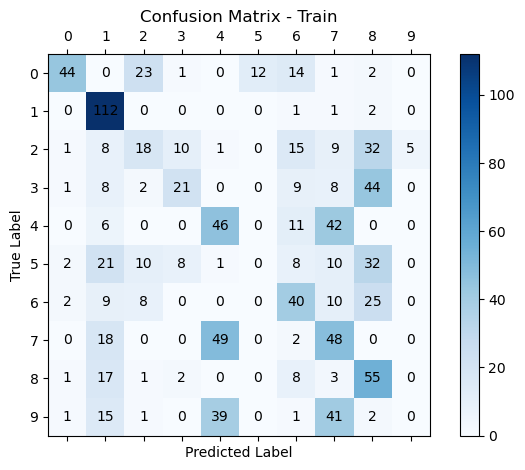

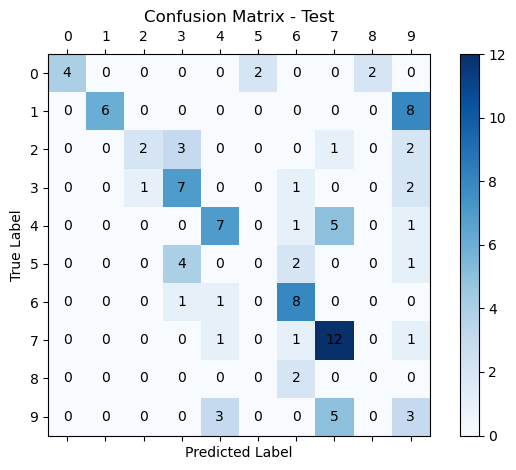

In [88]:
# Plot
plot_confusion_matrix(train_conf, "Confusion Matrix - Train")
plot_confusion_matrix(test_conf, "Confusion Matrix - Test")

# Discussion
### How well do hierarchical clusters align with digit classes?
Train Accuracy: 0.384<br>
Test Accuracy : 0.490<br>
이 결과를 봤을때 훈련 set은 38%의 정확도, 테스트 set에서는 49%의 정확도를 보였다.<br>
또 테스트 set의 Confusion Matrix를 보면 숫자 7, 3이 실제 라벨일때는 준수한 성능을 보이는 듯 하다.<br>
재미있는 점은 train set에서는 1을 구별하는 정확도가 높은 반면 test set에서는 9와 많이 혼동하는 모습을 보인다<br>
그 외에는 test set을 봤을 때때 4는 7과, 9는 7과 혼동을 많이 하는것으로 보인다.<br>

### Try different linkage methods: 'single', 'complete', 'ward’ 

In [89]:
from sklearn.cluster import AgglomerativeClustering

linkages = ['average', 'single', 'complete', 'ward']
results = {}              # {linkage: (train_acc, test_acc)}

for li in linkages:
    # ---------- Train ----------
    if li == 'ward':
        hier = AgglomerativeClustering(n_clusters=n_c, linkage=li)
    else:
        hier = AgglomerativeClustering(n_clusters=n_c, linkage=li, metric='euclidean')
    
    pred_train_y = hier.fit_predict(sub_PCA_train_x)
    train_acc, train_conf, train_mapped = compute_cluster_accuracy(
        sub_train_y['label'], pred_train_y, n_clusters=n_c
    )

    # ---------- Test ----------
    if li == 'ward':
        hier_test = AgglomerativeClustering(n_clusters=n_c, linkage=li)
    else:
        hier_test = AgglomerativeClustering(n_clusters=n_c, linkage=li, metric='euclidean')
    
    pred_test_y = hier_test.fit_predict(sub_PCA_test_x)
    test_acc, test_conf, test_mapped = compute_cluster_accuracy(
        sub_test_y['label'], pred_test_y, n_clusters=n_c
    )

    results[li] = (train_acc, test_acc)

# ---- 출력 ----
print(" Linkage | Train | Test")
print("---------------------------")
for li, (tr, te) in results.items():
    print(f"{li:<9}| {tr:.3f} | {te:.3f}")


 Linkage | Train | Test
---------------------------
average  | 0.384 | 0.490
single   | 0.121 | 0.200
complete | 0.358 | 0.410
ward     | 0.380 | 0.550


ward방법이 가장 테스트 성능이 좋게 나왔다.<br> 하지만 여전히 테스트 세트 또한 절반정도의 정확도를 보이는 것을 보아 그렇게 효과적인 방법은 아닌 듯 하다.

### Would using more data improve the clusters? Why or why not?

지금의 문제는 PCA를 사용하여 2차원으로 만들면서 생긴 정보 손실이 가장 큰 원인으로 보인다. 데이터를 더 늘린다고 하여도 복잡한 영역은 그대로 유지될 것 같다.<br>
따라서 데이터를 증가시킨다고 해도 크게 효과는 없어 보인다.